In [276]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import torch
from torch.utils.data import TensorDataset, DataLoader
import joblib
import torch
import random
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
import torch.optim as optim

from tqdm import tqdm
import numpy as np
df = pd.read_csv('/kaggle/input/yahoofi/stock_details_5_years.csv')

    
print("✅ Original Data:")
print(f"📐 Shape: {df.shape}")
print(f"🧾 Columns: {df.columns.tolist()}")
print("\n🔍 Sample Data:")
print(df.head())

# Drop rows with missing values (if any)
df = df.dropna()

# Convert and sort by date
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date').reset_index(drop=True)

aal_df = df[df['Company'] == 'AAPL'].copy()
aal_df.set_index('Date', inplace=True)  # Set date as index for time-based operations
print(f"AAPL Stock Data Shape: {aal_df.shape}")


# Select features and target
feature_cols = ['Open', 'High', 'Low', 'Close', 'Volume']
target_col = 'Close'

features = aal_df[feature_cols].values.astype(np.float32)
target = aal_df[target_col].values.astype(np.float32)

# Normalize features and target separately
feature_scaler = StandardScaler()
target_scaler = StandardScaler()


scaled_features = feature_scaler.fit_transform(features)
scaled_target = target_scaler.fit_transform(target.reshape(-1, 1))
# Save the scaler for inference
joblib.dump(target_scaler, 'target_scaler.pkl')

# Print scaler stats (verify)
print(f"Original mean: ${target_scaler.mean_[0]:.2f}")
print(f"Original std: ${target_scaler.scale_[0]:.2f}")
# Create sequences with multiple features
def create_sequences(features, target, seq_length, pred_length):
    X, y = [], []
    for i in range(len(features) - seq_length - pred_length + 1):
        X.append(features[i:i+seq_length])  # Shape: (seq_length, num_features)
        y.append(target[i+seq_length:i+seq_length+pred_length])  # Shape: (pred_length,)
    return np.array(X), np.array(y)

SEQ_LENGTH = 10
PRED_LENGTH = 1

X, y = create_sequences(scaled_features, scaled_target, SEQ_LENGTH, PRED_LENGTH)
total_size = len(X)
train_size = int(0.7 * total_size)  # 60% training
val_size = int(0.15 * total_size)    # 20% validation
# test_size = total_size - train_size - val_size (remaining 20%)

X_train, y_train = X[:train_size], y[:train_size]
X_val, y_val = X[train_size:train_size+val_size], y[train_size:train_size+val_size]
X_test, y_test = X[train_size+val_size:], y[train_size+val_size:]

print(f"Dataset sizes:")
print(f"Training: {X_train.shape[0]} sequences")
print(f"Validation: {X_val.shape[0]} sequences")
print(f"Testing: {X_test.shape[0]} sequences")

X_train_tensor = torch.tensor(X_train).float()
y_train_tensor = torch.tensor(y_train).float()
X_val_tensor = torch.tensor(X_val).float()
y_val_tensor = torch.tensor(y_val).float()
X_test_tensor = torch.tensor(X_test).float()
y_test_tensor = torch.tensor(y_test).float()

# Create DataLoaders
batch_size = 16
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)


for batch in train_loader:
    print(batch[0].shape)  # for a single tensor
    break

for batch in train_loader:
    print(batch[0].shape)  # for a single tensor
    break

✅ Original Data:
📐 Shape: (602962, 9)
🧾 Columns: ['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Dividends', 'Stock Splits', 'Company']

🔍 Sample Data:
                        Date        Open        High         Low       Close  \
0  2018-11-29 00:00:00-05:00   43.829761   43.863354   42.639594   43.083508   
1  2018-11-29 00:00:00-05:00  104.769074  105.519257  103.534595  104.636131   
2  2018-11-29 00:00:00-05:00   54.176498   55.007500   54.099998   54.729000   
3  2018-11-29 00:00:00-05:00   83.749496   84.499496   82.616501   83.678497   
4  2018-11-29 00:00:00-05:00   39.692784   40.064904   38.735195   39.037853   

      Volume  Dividends  Stock Splits Company  
0  167080000       0.00           0.0    AAPL  
1   28123200       0.00           0.0    MSFT  
2   31004000       0.00           0.0   GOOGL  
3  132264000       0.00           0.0    AMZN  
4   54917200       0.04           0.0    NVDA  


/tmp/ipykernel_35/3647349505.py:29: FutureWarning: In a future version of pandas, parsing datetimes with mixed time zones will raise an error unless `utc=True`. Please specify `utc=True` to opt in to the new behaviour and silence this warning. To create a `Series` with mixed offsets and `object` dtype, please use `apply` and `datetime.datetime.strptime`
  df['Date'] = pd.to_datetime(df['Date'])


AAPL Stock Data Shape: (1258, 8)
Original mean: $118.99
Original std: $46.98
Dataset sizes:
Training: 873 sequences
Validation: 187 sequences
Testing: 188 sequences
torch.Size([16, 10, 5])
torch.Size([16, 10, 5])


In [277]:
import torch
import torch.nn as nn
import torch.optim as optim
import math
from torch.utils.data import DataLoader, TensorDataset

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super(PositionalEncoding, self).__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        return x + self.pe[:x.size(0), :]

class StockTransformerDecoder(nn.Module):
    def __init__(self, input_features=5, d_model=256, nhead=8, num_layers=6, dropout=0.2):
        super(StockTransformerDecoder, self).__init__()
        
        # Input embedding
        self.embedding = nn.Linear(input_features, d_model)
        
        # Positional encoding
        self.pos_encoder = PositionalEncoding(d_model)
        
        # Decoder layers with masked self-attention
        decoder_layer = nn.TransformerDecoderLayer(d_model, nhead, dim_feedforward=d_model*4, dropout=dropout)
        self.transformer_decoder = nn.TransformerDecoder(decoder_layer, num_layers)
        
        # Output projection (predicts next day's close)
        self.output_proj = nn.Linear(d_model, 1)
        
        # Initialize weights
        self.init_weights()
        self.d_model = d_model

    def init_weights(self):
        initrange = 0.1
        self.embedding.weight.data.uniform_(-initrange, initrange)
        self.output_proj.bias.data.zero_()
        self.output_proj.weight.data.uniform_(-initrange, initrange)

    def forward(self, src):
        # src shape: (batch_size, seq_len=5, input_features)
        src = src.transpose(0, 1)  # (seq_len, batch_size, features)
        
        # Create target mask (triangular) for autoregressive prediction
        tgt_mask = nn.Transformer.generate_square_subsequent_mask(src.size(0)).to(src.device)
        
        # Embed and add positional encoding
        src = self.embedding(src) * math.sqrt(self.d_model)
        src = self.pos_encoder(src)
        
        # Decoder processing (using src as both memory and tgt for self-attention)
        # Note: In decoder-only, we typically use the same sequence for both target and memory
        output = self.transformer_decoder(
            tgt=src,  # target sequence
            memory=src,  # memory (same as target in decoder-only)
            tgt_mask=tgt_mask  # prevents looking ahead
        )
        
        # Take the last time step's output
        last_output = output[-1]
        
        # Project to single value (next day's close)
        return self.output_proj(last_output).squeeze(-1)

# Usage example
model = StockTransformerDecoder(input_features=5)
x = torch.randn(32, 5, 5)  # batch of 32 sequences, each 5 days, 5 features
y = model(x)  # predicts next day's close for each sequence
print(y.shape)  # torch.Size([32])

torch.Size([32])


Epoch   | Train Loss   | Val Loss   | Time   | Status
--------------------------------------------------


1       | 0.807074 | 0.144011 | 1.64s | ✅ Improved


2       | 0.059682 | 0.060443 | 1.71s | ✅ Improved


3       | 0.044005 | 0.062134 | 1.62s | ⏳ No improvement


4       | 0.044512 | 0.024986 | 1.62s | ✅ Improved


5       | 0.046956 | 0.012465 | 1.64s | ✅ Improved


6       | 0.027975 | 0.057848 | 1.54s | ⏳ No improvement


7       | 0.028345 | 0.037138 | 1.58s | ⏳ No improvement


8       | 0.027911 | 0.020779 | 1.55s | ⏳ No improvement


9       | 0.022975 | 0.007086 | 1.62s | ✅ Improved


10      | 0.031909 | 0.090525 | 1.55s | ⏳ No improvement


11      | 0.023744 | 0.008522 | 1.61s | ⏳ No improvement


12      | 0.015977 | 0.083695 | 1.58s | ⏳ No improvement


13      | 0.022028 | 0.044559 | 1.56s | ⏳ No improvement


14      | 0.013192 | 0.006852 | 1.62s | ✅ Improved


15      | 0.009899 | 0.006658 | 1.60s | ✅ Improved


16      | 0.010718 | 0.007242 | 1.59s | ⏳ No improvement


17      | 0.010436 | 0.007757 | 1.52s | ⏳ No improvement


18      | 0.012120 | 0.038726 | 1.55s | ⏳ No improvement


19      | 0.009522 | 0.020449 | 1.56s | ⏳ No improvement


Early stopping at epoch 20

Training Complete!
Best Validation Loss: 0.006658


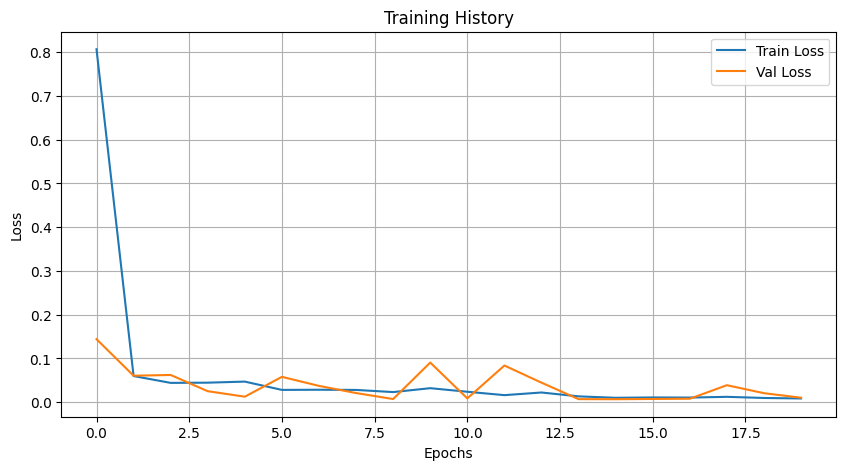

In [278]:
from tqdm import tqdm
import time
import matplotlib.pyplot as plt
import random
import numpy as np

# Fix seeds for reproducibility
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
set_seed()
# Enhanced Loss Function

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def train_transformer(model, train_loader, val_loader, num_epochs=50, learning_rate=0.001, patience=5):
    """Train the Transformer model with enhancements for decoder-only architecture"""
    # Move model to device
    model = model.to(device)
    
    criterion = nn.MSELoss()
    optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=0.01)
    
    # Changed to ReduceLROnPlateau for better stability with time series
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, 
        mode='min', 
        factor=0.5, 
        patience=3, 
        verbose=True
    )
    
    train_losses = []
    val_losses = []
    best_loss = float('inf')
    patience_counter = 0
    
    print(f"{'Epoch':<7} | {'Train Loss':<12} | {'Val Loss':<10} | {'Time':<6} | Status")
    print("-" * 50)
    
    for epoch in range(num_epochs):
        epoch_start = time.time()
        model.train()
        train_loss = 0
        
        # Batch gradient clipping for Transformer stability
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        
        with tqdm(train_loader, unit="batch", leave=False) as tepoch:
            tepoch.set_description(f"Epoch {epoch+1}/{num_epochs}")
            for X_batch, y_batch in tepoch:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                
                optimizer.zero_grad()
                outputs = model(X_batch)
                loss = criterion(outputs, y_batch.squeeze())
                loss.backward()
                
                # Gradient clipping
                torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5)
                
                optimizer.step()
                train_loss += loss.item()
                tepoch.set_postfix(loss=loss.item())
        
        # Validation
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for X_val, y_val in val_loader:
                X_val, y_val = X_val.to(device), y_val.to(device)
                outputs = model(X_val)
                val_loss += criterion(outputs, y_val.squeeze()).item()
        
        # Calculate averages
        train_loss /= len(train_loader)
        val_loss /= len(val_loader)
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        
        # Update learning rate
        scheduler.step(val_loss)
        
        # Early stopping check
        if val_loss < best_loss:
            best_loss = val_loss
            patience_counter = 0
            torch.save(model.state_dict(), 'best_transformer.pth')
            status = "✅ Improved"
        else:
            patience_counter += 1
            status = "⏳ No improvement"
            if patience_counter >= patience:
                status = "🛑 Early Stop"
                print(f"Early stopping at epoch {epoch+1}")
                break
        
        epoch_time = time.time() - epoch_start
        print(f"{epoch+1:<7} | {train_loss:.6f} | {val_loss:.6f} | {epoch_time:.2f}s | {status}")

    # Final report
    print("\nTraining Complete!")
    print(f"Best Validation Loss: {best_loss:.6f}")
    
    # Plot training history
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Val Loss')
    plt.legend()
    plt.title("Training History")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.grid(True)
    plt.show()
    
    return model

trained_model = train_transformer(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    num_epochs=50,
    learning_rate=0.001,
    patience=5  # early stopping after 5 epochs without improvement
)

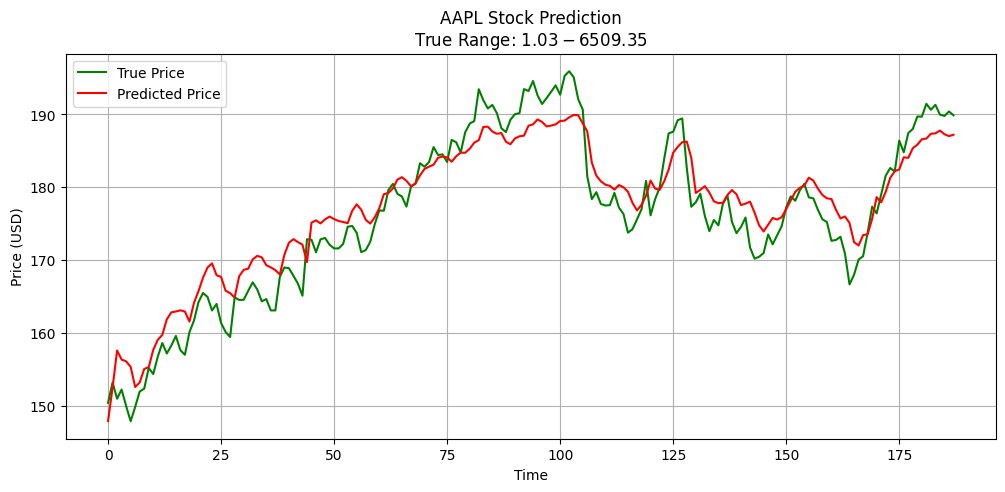


Normalized Metrics:
RMSE: 0.0771
MAE: 0.0659
R²: 0.8973

Denormalized Metrics (USD):
RMSE: $3.62 (2.6% of mean price)
MAE: $3.10
MAPE (>$5 prices): 1.78%


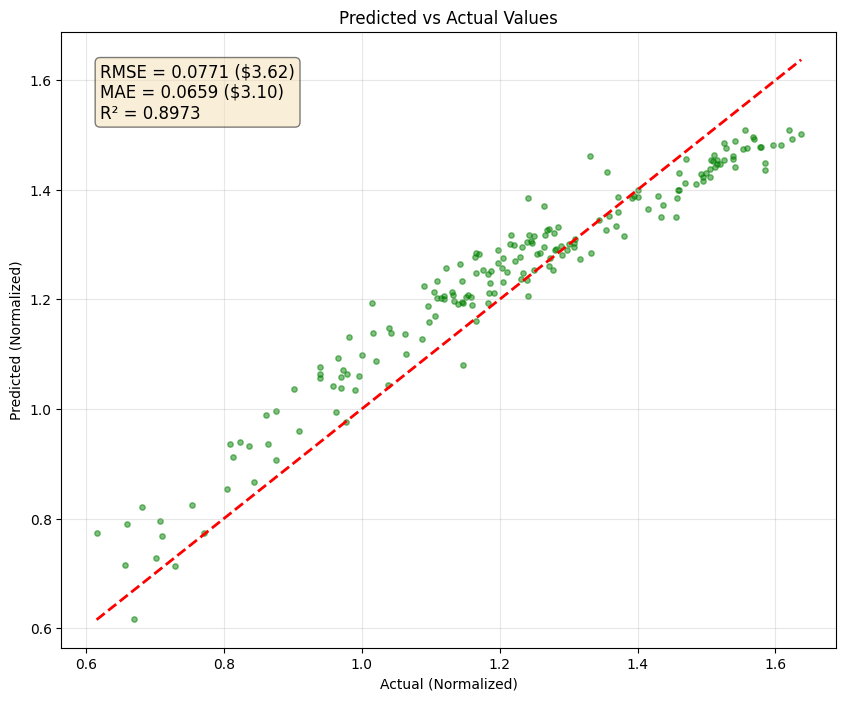

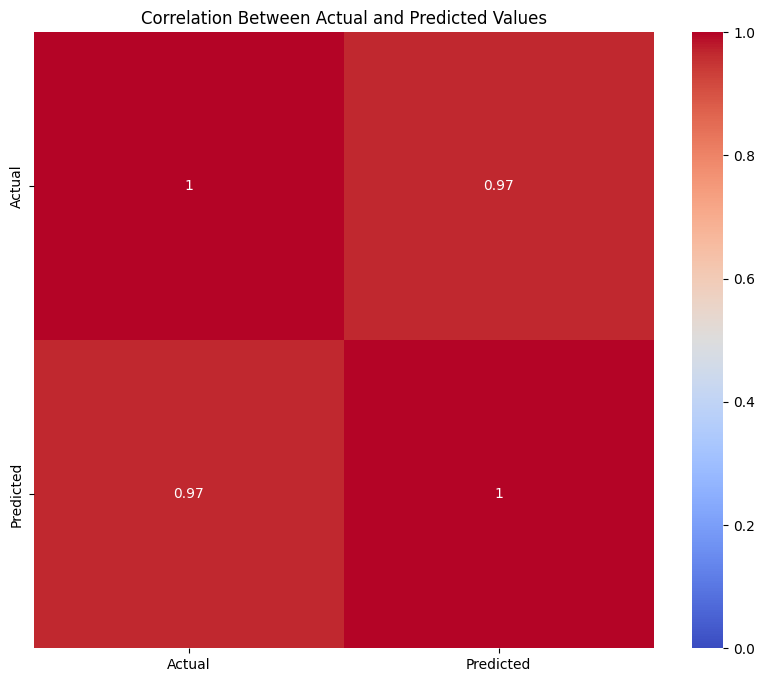

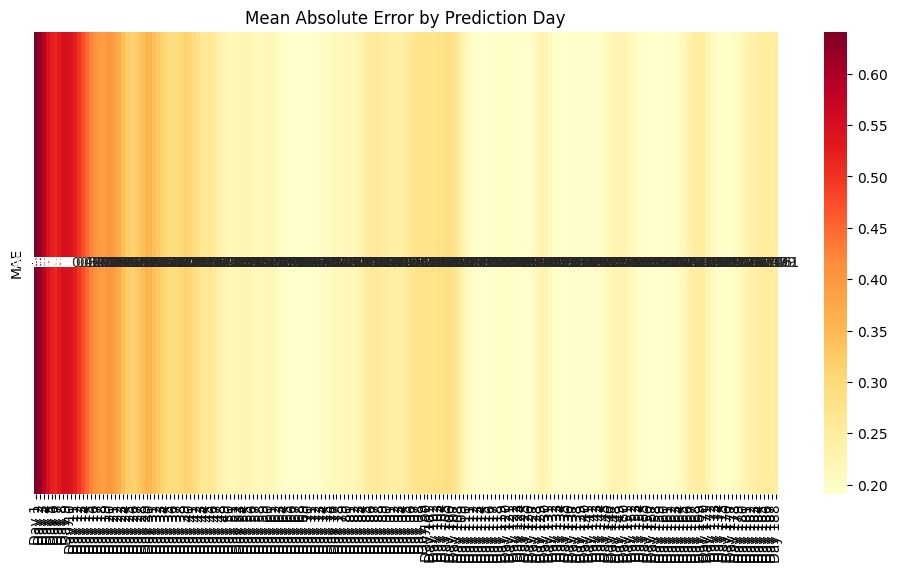

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


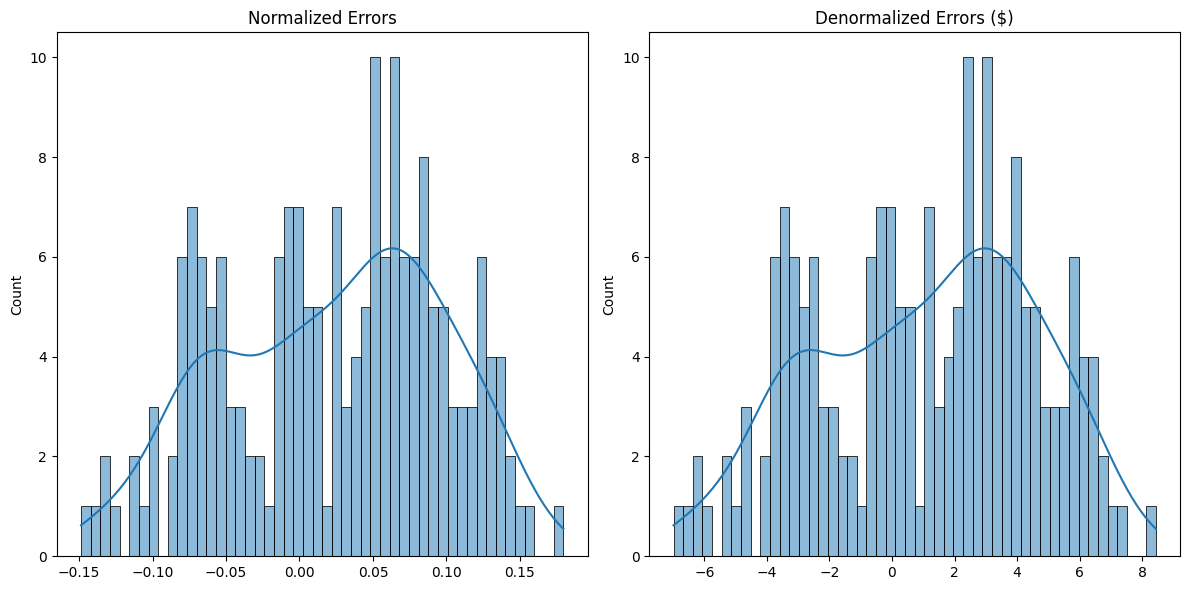

In [279]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

def test_transformer(model, test_loader, target_scaler, original_prices_df):
    """
    Comprehensive testing with enhanced visualizations for decoder-only Transformer
    Args:
        model: Trained decoder-only Transformer
        test_loader: Test data loader (batch_size, seq_len=5, features=5)
        target_scaler: Fitted scaler for inverse transform
        original_prices_df: DataFrame with dates and true prices
    """
    model.eval()
    all_preds = []
    all_true = []
    
    # Store sample sequences for visualization
    sample_sequences = {
        'inputs': [],  # Last 5 days of features
        'preds': [],   # Predicted next day
        'trues': []    # Actual next day
    }
    
    with torch.no_grad():
        for i, (X_test, y_test) in enumerate(test_loader):
            X_test, y_test = X_test.to(device), y_test.to(device)
            outputs = model(X_test)
            
            all_preds.extend(outputs.cpu().numpy())
            all_true.extend(y_test.squeeze().cpu().numpy())
            
            # Store first 3 samples for visualization
            if i < 3:
                sample_sequences['inputs'].append(X_test.cpu().numpy()[0])
                sample_sequences['preds'].append(outputs.cpu().numpy()[0])
                sample_sequences['trues'].append(y_test.cpu().numpy()[0])
    
    # Convert to numpy arrays
    y_pred = np.array(all_preds)
    y_true = np.array(all_true)
    
    # Inverse transform if scaler provided
    y_pred_denorm = target_scaler.inverse_transform(y_pred.reshape(-1, 1)).flatten()
    y_true_denorm = target_scaler.inverse_transform(y_true.reshape(-1, 1)).flatten()
    
    # Calculate metrics
    original_mean = original_prices_df['Close'].mean()
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    
    rmse_denorm = np.sqrt(mean_squared_error(y_true_denorm, y_pred_denorm))
    mae_denorm = mean_absolute_error(y_true_denorm, y_pred_denorm)
    
    # Calculate MAPE only for prices > $5
    valid_prices_mask = y_true_denorm > 5
    mape_denorm = np.mean(np.abs((y_true_denorm[valid_prices_mask] - y_pred_denorm[valid_prices_mask]) / 
                         y_true_denorm[valid_prices_mask])) * 100

    # 1. Time-series comparison plot with USD values
    plt.figure(figsize=(12, 5))
    plt.plot(y_true_denorm, label="True Price", color='green')
    plt.plot(y_pred_denorm, label="Predicted Price", color='red')
    plt.title(f"AAPL Stock Prediction\nTrue Range: ${original_prices_df['Close'].min():.2f}-${original_prices_df['Close'].max():.2f}")
    plt.xlabel("Time")
    plt.ylabel("Price (USD)")
    plt.legend()
    plt.grid(True)
    plt.show()

    # Print metrics
    print(f"\nNormalized Metrics:")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAE: {mae:.4f}")
    print(f"R²: {r2:.4f}")

    print(f"\nDenormalized Metrics (USD):")
    print(f"RMSE: ${rmse_denorm:.2f} ({(rmse_denorm/original_mean)*100:.1f}% of mean price)")
    print(f"MAE: ${mae_denorm:.2f}")
    print(f"MAPE (>$5 prices): {mape_denorm:.2f}%")

   

    # 3. Scatter plot with metrics
    plt.figure(figsize=(10, 8))
    plt.scatter(y_true, y_pred, alpha=0.5, c='green', s=15)
    plt.plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], 'r--', linewidth=2)
    plt.title("Predicted vs Actual Values")
    plt.xlabel("Actual (Normalized)")
    plt.ylabel("Predicted (Normalized)")
    plt.grid(alpha=0.3)
    
    textstr = '\n'.join((
        f'RMSE = {rmse:.4f} (${rmse_denorm:.2f})',
        f'MAE = {mae:.4f} (${mae_denorm:.2f})',
        f'R² = {r2:.4f}'
    ))
    
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    plt.gca().text(0.05, 0.95, textstr, transform=plt.gca().transAxes,
                  fontsize=12, verticalalignment='top', bbox=props)
    plt.show()
    # Correlation Heatmap
    plt.figure(figsize=(10, 8))
    correlation_matrix = np.corrcoef(y_true, y_pred)
    sns.heatmap(correlation_matrix, annot=True, 
            xticklabels=['Actual', 'Predicted'], 
            yticklabels=['Actual', 'Predicted'],
            cmap='coolwarm', vmin=0, vmax=1)
    plt.title('Correlation Between Actual and Predicted Values')
    plt.show() 

    # Calculate absolute errors for each prediction day
    abs_errors = np.abs(all_predictions - all_ground_truth)
    mean_errors_by_day = np.mean(abs_errors, axis=0)

    plt.figure(figsize=(12, 6))
    sns.heatmap(mean_errors_by_day.reshape(1, -1), 
            annot=True, fmt=".4f",
            cmap="YlOrRd",
            xticklabels=[f"Day {i+1}" for i in range(mean_errors_by_day.shape[0])],
            yticklabels=['MAE'])
    plt.title('Mean Absolute Error by Prediction Day')
    plt.show() 

    # 4. Error distribution plots
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    errors_norm = y_pred - y_true
    sns.histplot(errors_norm, kde=True, bins=50)
    plt.title('Normalized Errors')
    
    plt.subplot(1, 2, 2)
    errors_denorm = y_pred_denorm - y_true_denorm
    sns.histplot(errors_denorm, kde=True, bins=50)
    plt.title('Denormalized Errors ($)')
    plt.tight_layout()
    plt.show()

    return {
        'rmse': rmse,
        'mae': mae,
        'r2': r2,
        'rmse_denorm': rmse_denorm,
        'mae_denorm': mae_denorm,
        'mape_denorm': mape_denorm
    }

# Example usage:
test_results = test_transformer(trained_model, test_loader, target_scaler, df)